In [1]:
import os
import cv2 
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import streamlit as st
import tensorflow as tf 
import matplotlib.pyplot as plt   
from sklearn.utils import shuffle  
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-02-06 10:14:01.826500: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 10:14:01.915235: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 10:14:02.607884: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 10:14:02.611826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 10:14:03.634086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)
nb_classes

6

In [3]:
def load_data(num_images_per_class=1000):
    
    datasets = ['/home/sesna/sesna/image_classification/data', '/home/sesna/sesna/image_classification/seg_test']
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Track the number of images loaded for each class
            images_loaded = 0
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                if images_loaded >= num_images_per_class:
                    break  # Break the loop if the desired number of images is reached for this class
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                images.append(image)
                labels.append(label)
                
                # Increment the count of images loaded for this class
                images_loaded += 1
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')   
        
        output.append((images, labels))

    return output


In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /home/sesna/sesna/image_classification/data


 44%|████▍     | 1000/2271 [00:00<00:00, 1612.36it/s]


Loading /home/sesna/sesna/image_classification/seg_test


100%|██████████| 474/474 [00:00<00:00, 1557.90it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 6000
Number of testing examples: 3000
Each image is of size: (150, 150)


In [7]:
train_images = train_images / 255.0 


In [8]:
test_images = test_images / 255.0

In [9]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.4)

Epoch 1/10
29/29 [==============================] - 15s 482ms/step - loss: 1.2649 - accuracy: 0.5011 - val_loss: 1.0354 - val_accuracy: 0.6021
Epoch 2/10
29/29 [==============================] - 14s 500ms/step - loss: 0.9323 - accuracy: 0.6431 - val_loss: 0.8745 - val_accuracy: 0.6721
Epoch 3/10
29/29 [==============================] - 15s 529ms/step - loss: 0.7423 - accuracy: 0.7275 - val_loss: 0.8655 - val_accuracy: 0.6725
Epoch 4/10
29/29 [==============================] - 14s 469ms/step - loss: 0.6220 - accuracy: 0.7772 - val_loss: 0.8217 - val_accuracy: 0.6942
Epoch 5/10
29/29 [==============================] - 14s 476ms/step - loss: 0.4522 - accuracy: 0.8439 - val_loss: 0.7038 - val_accuracy: 0.7550
Epoch 6/10
29/29 [==============================] - 14s 484ms/step - loss: 0.3074 - accuracy: 0.9047 - val_loss: 0.7142 - val_accuracy: 0.7504
Epoch 7/10
29/29 [==============================] - 14s 470ms/step - loss: 0.2322 - accuracy: 0.9256 - val_loss: 1.3676 - val_accuracy: 0.6146

In [12]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

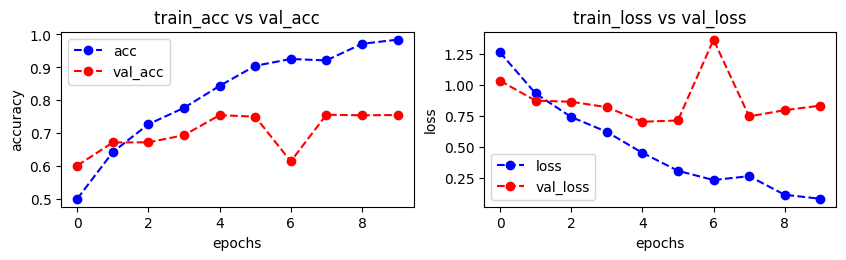

In [13]:
plot_accuracy_loss(history)

In [14]:
test_loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {accuracy}')


94/94 [==============================] - 3s 34ms/step - loss: 0.9073 - accuracy: 0.7440
Test Loss: 0.9073020815849304
Test Accuracy: 0.7440000176429749


In [15]:
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1) 
Accuracy = accuracy_score(test_labels,pred_labels)
Accuracy

94/94 [==============================] - 3s 33ms/step


0.744

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [17]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.4, random_state=42)

In [18]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [19]:
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding your own top layers on top of the pre-trained VGG16 base
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [20]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(train_images, train_labels, validation_split=0.04,epochs=10, batch_size=128)

Epoch 1/10
27/27 [==============================] - 158s 6s/step - loss: 0.7019 - accuracy: 0.7321 - val_loss: 0.4493 - val_accuracy: 0.8194
Epoch 2/10
27/27 [==============================] - 168s 6s/step - loss: 0.3202 - accuracy: 0.8822 - val_loss: 0.4941 - val_accuracy: 0.8472
Epoch 3/10
27/27 [==============================] - 171s 6s/step - loss: 0.2318 - accuracy: 0.9204 - val_loss: 0.3805 - val_accuracy: 0.8542
Epoch 4/10
27/27 [==============================] - 171s 6s/step - loss: 0.1522 - accuracy: 0.9523 - val_loss: 0.5220 - val_accuracy: 0.8264
Epoch 5/10
27/27 [==============================] - 168s 6s/step - loss: 0.1403 - accuracy: 0.9552 - val_loss: 0.4266 - val_accuracy: 0.8542
Epoch 6/10
27/27 [==============================] - 171s 6s/step - loss: 0.0859 - accuracy: 0.9783 - val_loss: 0.4382 - val_accuracy: 0.8403
Epoch 7/10
27/27 [==============================] - 169s 6s/step - loss: 0.0586 - accuracy: 0.9861 - val_loss: 0.4625 - val_accuracy: 0.8681
Epoch 8/10
27

In [23]:
with open('training_history1.pkl', 'wb') as file:
   pickle.dump(history.history, file)

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

94/94 [==============================] - 134s 1s/step - loss: 0.5678 - accuracy: 0.8373
Test Accuracy: 83.73%


In [24]:
from tensorflow.keras.models import load_model

In [25]:
model.save(os.path.join('models','imageclassifier1.h5'))

/home/sesna/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
